# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

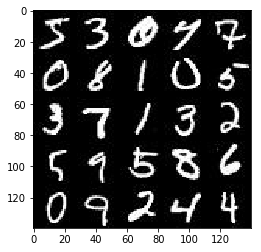

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

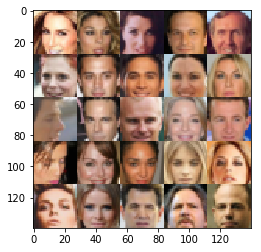

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # DONE: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, lr

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "c:\\users\\peter\\anaconda3\\envs\\tflearn-gpu\\lib\\runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "c:\\users\\peter\\anaconda3\\envs\\tflearn-gpu\\lib\\runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "c:\\users\\peter\\anaconda3\\envs\\tflearn-gpu\\lib\\site-packages\\ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "c:\\users\\peter\\anaconda3\\envs\\tflearn-gpu\\lib\\site-packages\\traitlets\\config\\application.py", line 658, in launch_instance\n    app.start()', 'File "c:\\users\\peter\\anaconda3\\envs\\tflearn-gpu\\lib\\site-packages\\ipykernel\\kernelapp.py", line 477, in start\n    ioloop.IOLoop.instan

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.01):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # DONE: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28 x 28 x out_channel_dim
        #print(images.get_shape().as_list())
        
        # conv to 14, 14, 128
        x = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        x = tf.maximum(alpha * x, x)
        #print(x.get_shape().as_list())
        
        # conv to 7, 7, 256
        x = tf.layers.conv2d(x, 256, 5, strides=2, padding='same', use_bias=False)
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha * x, x)
        #print(x.get_shape().as_list())
        
        # conv to 4, 4, 512
        x = tf.layers.conv2d(x, 512, 5, strides=2, padding='same', use_bias=False)
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha * x, x)
        #print(x.get_shape().as_list())
        
        # flatten
        x = tf.reshape(x, (-1, 4*4*512))
        #print(x.get_shape().as_list())
        
        # logits and output
        logits = tf.layers.dense(x, 1)
        out = tf.sigmoid(logits)
        
        
        return out, logits
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.02): # I put alpha parameter to this function call
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # DONE: Implement Function
    
    # auxiliar variables
    reuse = not is_train
    
    # scope for generator
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x = tf.layers.dense(z, 4*4*512)
        #print(x.get_shape().as_list())
        
        # batch normalization to 4x4x512
        x = tf.reshape(x, (-1, 4, 4, 512))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        #print(x.get_shape().as_list())
        
        
        # conv to 7x7x256
        x = tf.layers.conv2d_transpose(x, 256, 4, strides=1, padding='valid')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        #print(x.get_shape().as_list())
        
            
        # conv to 14x14x128        
        x = tf.layers.conv2d_transpose(x, 128, 5, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        #print(x.get_shape().as_list())
        
        # Output layer, 28 x 28 x out_channel_dim (3 or 1, depending on the task - faces or minst)
        logits = tf.layers.conv2d_transpose(x, out_channel_dim, 5, strides=2, padding='same')
        #print(logits.get_shape().as_list())
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
smooth = 0.1

def model_loss(input_real, input_z, out_channel_dim, alpha=0.02): # I put alpha parameter to this function call
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # DONE: Implement Function
    
    # Just for reference:
    #   discriminator(images, reuse=False, alpha=0.01)
    #   generator(z, out_channel_dim, is_train=True, alpha=0.02): # I put alpha parameter to this function call
    
    g_out = generator(input_z, out_channel_dim, alpha=alpha)
    d_out_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_out_fake, d_logits_fake = discriminator(g_out, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                                                        logits=d_logits_real,
                                                        labels=tf.ones_like(d_out_real) * (1. - smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                                                        logits=d_logits_fake,
                                                        labels=tf.zeros_like(d_out_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                                                        logits=d_logits_fake,
                                                        labels=tf.ones_like(d_out_fake)))

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # DONE: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
from datetime import datetime

print_every = 10
show_every = 100
n_images = 16
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # DONE: Build Model
    minput_real, minput_z, mlearning_rate = model_inputs(*data_shape[1:], z_dim)
    d_loss, g_loss = model_loss(minput_real, minput_z, data_shape[-1], alpha=0.02)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    have_i_already_reset_the_default_graph = True

    # Auxiliar variables
    steps = 0
    out_channel_dim = 3 if data_image_mode == 'RGB' else 1
    sample_z = np.random.uniform(-1, 1, size=(n_images, z_dim))

    #there is a problem redefining related to redefining a session. This is a workaround
    #(https://stackoverflow.com/questions/37934955/tensorflow-op-naming-for-consecutive-runs-in-interactive-ipython-terminal)
        
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):    
            for batch_images in get_batches(batch_size):
                # DONE: Train Model
                steps += 1
                
                # rescale from [-.5, .5] to [-1., 1.]
                batch_images = batch_images * 2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                #_ = sess.run(net.d_opt, feed_dict={net.input_real: batch_images, net.input_z: batch_z, net.learning_rate : learning_rate})
                #_ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.learning_rate : learning_rate, net.input_real: batch_images})
                _ = sess.run(d_opt, feed_dict={minput_real: batch_images, minput_z: batch_z, mlearning_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={minput_z: batch_z, mlearning_rate: learning_rate, minput_real: batch_images})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    #train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: batch_images})
                    #train_loss_g = net.g_loss.eval({net.input_z: batch_z})
                    train_loss_d = d_loss.eval({minput_z: batch_z, minput_real: batch_images})
                    train_loss_g = g_loss.eval({minput_z: batch_z})

                    print("Timestamp {} - ".format(datetime.now().strftime('%Y%m%d-%H-%M-%S.%f')[:-3]),
                          "Epoch {}/{} - ".format(epoch_i+1, epochs),
                          "Step {} - ".format(steps),
                          "D Loss: {:.4f} -".format(train_loss_d),
                          "G Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, n_images, minput_z, out_channel_dim, data_image_mode)

            # At the end of each epoch, get the losses and print them out
            if not (steps % show_every == 0):
                train_loss_d = d_loss.eval({minput_z: batch_z, minput_real: batch_images})
                train_loss_g = g_loss.eval({minput_z: batch_z})
                print("Timestamp {} - ".format(datetime.now().strftime('%Y%m%d-%H-%M-%S.%f')[:-3]),
                      "Epoch {}/{} - ".format(epoch_i+1, epochs),
                      "Step {} - ".format(steps),
                      "D Loss: {:.4f} -".format(train_loss_d),
                      "G Loss: {:.4f}".format(train_loss_g))

                show_generator_output(sess, n_images, minput_z, out_channel_dim, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Timestamp 20170801-03-37-07.766 -  Epoch 1/2 -  Step 10 -  D Loss: 2.2011 - G Loss: 1.0718
Timestamp 20170801-03-37-20.233 -  Epoch 1/2 -  Step 20 -  D Loss: 1.3527 - G Loss: 2.0376
Timestamp 20170801-03-37-32.593 -  Epoch 1/2 -  Step 30 -  D Loss: 0.4222 - G Loss: 5.5403
Timestamp 20170801-03-37-45.183 -  Epoch 1/2 -  Step 40 -  D Loss: 10.5552 - G Loss: 12.9964
Timestamp 20170801-03-37-57.755 -  Epoch 1/2 -  Step 50 -  D Loss: 3.4723 - G Loss: 0.5015
Timestamp 20170801-03-38-10.397 -  Epoch 1/2 -  Step 60 -  D Loss: 0.3619 - G Loss: 5.7805
Timestamp 20170801-03-38-22.715 -  Epoch 1/2 -  Step 70 -  D Loss: 0.4696 - G Loss: 2.7102
Timestamp 20170801-03-38-34.850 -  Epoch 1/2 -  Step 80 -  D Loss: 0.4148 - G Loss: 8.9011
Timestamp 20170801-03-38-47.035 -  Epoch 1/2 -  Step 90 -  D Loss: 0.3442 - G Loss: 6.1753
Timestamp 20170801-03-38-59.182 -  Epoch 1/2 -  Step 100 -  D Loss: 0.3564 - G Loss: 5.9271


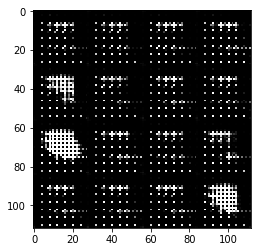

Timestamp 20170801-03-39-11.753 -  Epoch 1/2 -  Step 110 -  D Loss: 0.3416 - G Loss: 5.6182
Timestamp 20170801-03-39-23.877 -  Epoch 1/2 -  Step 120 -  D Loss: 0.3335 - G Loss: 7.1340
Timestamp 20170801-03-39-36.040 -  Epoch 1/2 -  Step 130 -  D Loss: 6.3630 - G Loss: 0.0181
Timestamp 20170801-03-39-48.173 -  Epoch 1/2 -  Step 140 -  D Loss: 0.4574 - G Loss: 3.5449
Timestamp 20170801-03-40-00.395 -  Epoch 1/2 -  Step 150 -  D Loss: 0.3757 - G Loss: 4.2049
Timestamp 20170801-03-40-12.938 -  Epoch 1/2 -  Step 160 -  D Loss: 0.6659 - G Loss: 4.4684
Timestamp 20170801-03-40-25.559 -  Epoch 1/2 -  Step 170 -  D Loss: 0.3569 - G Loss: 6.3631
Timestamp 20170801-03-40-38.097 -  Epoch 1/2 -  Step 180 -  D Loss: 3.2990 - G Loss: 0.2250
Timestamp 20170801-03-40-50.655 -  Epoch 1/2 -  Step 190 -  D Loss: 0.6511 - G Loss: 1.7710
Timestamp 20170801-03-41-03.219 -  Epoch 1/2 -  Step 200 -  D Loss: 1.7088 - G Loss: 0.6581


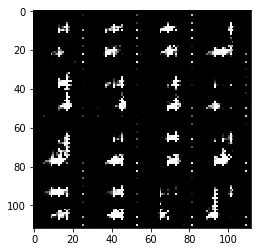

Timestamp 20170801-03-41-15.967 -  Epoch 1/2 -  Step 210 -  D Loss: 3.3106 - G Loss: 10.0267
Timestamp 20170801-03-41-28.380 -  Epoch 1/2 -  Step 220 -  D Loss: 2.1337 - G Loss: 0.5520
Timestamp 20170801-03-41-40.991 -  Epoch 1/2 -  Step 230 -  D Loss: 3.2167 - G Loss: 0.2472
Timestamp 20170801-03-41-53.560 -  Epoch 1/2 -  Step 240 -  D Loss: 0.4047 - G Loss: 3.7636
Timestamp 20170801-03-42-06.115 -  Epoch 1/2 -  Step 250 -  D Loss: 1.6137 - G Loss: 0.6312
Timestamp 20170801-03-42-18.689 -  Epoch 1/2 -  Step 260 -  D Loss: 0.6993 - G Loss: 3.5729
Timestamp 20170801-03-42-31.297 -  Epoch 1/2 -  Step 270 -  D Loss: 0.7000 - G Loss: 1.5538
Timestamp 20170801-03-42-43.830 -  Epoch 1/2 -  Step 280 -  D Loss: 1.1447 - G Loss: 1.9525
Timestamp 20170801-03-42-56.387 -  Epoch 1/2 -  Step 290 -  D Loss: 0.6272 - G Loss: 2.0744
Timestamp 20170801-03-43-08.992 -  Epoch 1/2 -  Step 300 -  D Loss: 1.3751 - G Loss: 0.9177


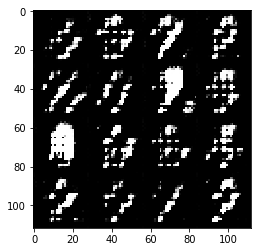

Timestamp 20170801-03-43-21.959 -  Epoch 1/2 -  Step 310 -  D Loss: 0.9859 - G Loss: 1.0793
Timestamp 20170801-03-43-34.534 -  Epoch 1/2 -  Step 320 -  D Loss: 0.8527 - G Loss: 1.5710
Timestamp 20170801-03-43-47.132 -  Epoch 1/2 -  Step 330 -  D Loss: 1.7065 - G Loss: 0.5704
Timestamp 20170801-03-43-59.667 -  Epoch 1/2 -  Step 340 -  D Loss: 0.8493 - G Loss: 1.8394
Timestamp 20170801-03-44-12.277 -  Epoch 1/2 -  Step 350 -  D Loss: 0.6528 - G Loss: 2.8086
Timestamp 20170801-03-44-25.073 -  Epoch 1/2 -  Step 360 -  D Loss: 0.8361 - G Loss: 1.3773
Timestamp 20170801-03-44-37.549 -  Epoch 1/2 -  Step 370 -  D Loss: 0.6564 - G Loss: 1.7610
Timestamp 20170801-03-44-50.109 -  Epoch 1/2 -  Step 380 -  D Loss: 0.5576 - G Loss: 2.5294
Timestamp 20170801-03-45-02.742 -  Epoch 1/2 -  Step 390 -  D Loss: 1.1280 - G Loss: 2.6587
Timestamp 20170801-03-45-15.344 -  Epoch 1/2 -  Step 400 -  D Loss: 1.1256 - G Loss: 1.1934


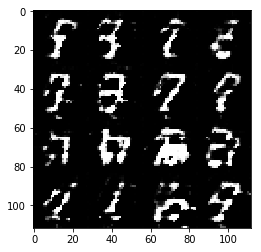

Timestamp 20170801-03-45-28.248 -  Epoch 1/2 -  Step 410 -  D Loss: 2.0058 - G Loss: 2.4637
Timestamp 20170801-03-45-40.837 -  Epoch 1/2 -  Step 420 -  D Loss: 0.7590 - G Loss: 3.5441
Timestamp 20170801-03-45-53.470 -  Epoch 1/2 -  Step 430 -  D Loss: 1.0177 - G Loss: 1.8367
Timestamp 20170801-03-46-06.046 -  Epoch 1/2 -  Step 440 -  D Loss: 1.1970 - G Loss: 1.9600
Timestamp 20170801-03-46-18.658 -  Epoch 1/2 -  Step 450 -  D Loss: 0.7489 - G Loss: 1.3882
Timestamp 20170801-03-46-31.233 -  Epoch 1/2 -  Step 460 -  D Loss: 1.1193 - G Loss: 2.7129
Timestamp 20170801-03-46-43.858 -  Epoch 1/2 -  Step 470 -  D Loss: 0.8491 - G Loss: 1.4415
Timestamp 20170801-03-46-56.484 -  Epoch 1/2 -  Step 480 -  D Loss: 0.8972 - G Loss: 1.2393
Timestamp 20170801-03-47-09.054 -  Epoch 1/2 -  Step 490 -  D Loss: 1.0367 - G Loss: 1.6223
Timestamp 20170801-03-47-21.675 -  Epoch 1/2 -  Step 500 -  D Loss: 0.9756 - G Loss: 0.9253


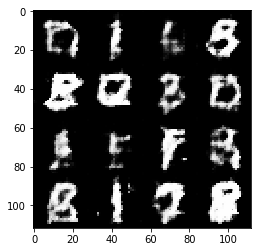

Timestamp 20170801-03-47-34.858 -  Epoch 1/2 -  Step 510 -  D Loss: 1.1669 - G Loss: 0.7989
Timestamp 20170801-03-47-47.145 -  Epoch 1/2 -  Step 520 -  D Loss: 1.5289 - G Loss: 0.5249
Timestamp 20170801-03-47-59.663 -  Epoch 1/2 -  Step 530 -  D Loss: 1.0220 - G Loss: 1.1043
Timestamp 20170801-03-48-12.253 -  Epoch 1/2 -  Step 540 -  D Loss: 0.8851 - G Loss: 1.3294
Timestamp 20170801-03-48-24.825 -  Epoch 1/2 -  Step 550 -  D Loss: 0.8303 - G Loss: 1.1871
Timestamp 20170801-03-48-37.426 -  Epoch 1/2 -  Step 560 -  D Loss: 0.7967 - G Loss: 1.2785
Timestamp 20170801-03-48-49.664 -  Epoch 1/2 -  Step 570 -  D Loss: 1.3938 - G Loss: 0.9094
Timestamp 20170801-03-49-01.798 -  Epoch 1/2 -  Step 580 -  D Loss: 0.9875 - G Loss: 2.3763
Timestamp 20170801-03-49-14.064 -  Epoch 1/2 -  Step 590 -  D Loss: 1.2908 - G Loss: 2.7068
Timestamp 20170801-03-49-26.575 -  Epoch 1/2 -  Step 600 -  D Loss: 0.9445 - G Loss: 1.1777


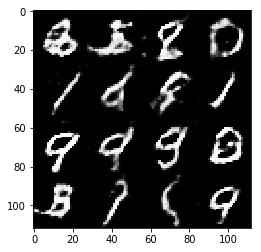

Timestamp 20170801-03-49-40.031 -  Epoch 1/2 -  Step 610 -  D Loss: 1.0948 - G Loss: 0.9790
Timestamp 20170801-03-49-52.604 -  Epoch 1/2 -  Step 620 -  D Loss: 1.8325 - G Loss: 3.7781
Timestamp 20170801-03-50-05.221 -  Epoch 1/2 -  Step 630 -  D Loss: 1.0282 - G Loss: 1.2695
Timestamp 20170801-03-50-17.833 -  Epoch 1/2 -  Step 640 -  D Loss: 1.4875 - G Loss: 0.4929
Timestamp 20170801-03-50-30.430 -  Epoch 1/2 -  Step 650 -  D Loss: 1.1314 - G Loss: 0.8403
Timestamp 20170801-03-50-43.061 -  Epoch 1/2 -  Step 660 -  D Loss: 0.8136 - G Loss: 1.3213
Timestamp 20170801-03-50-55.668 -  Epoch 1/2 -  Step 670 -  D Loss: 0.9643 - G Loss: 1.5171
Timestamp 20170801-03-51-08.252 -  Epoch 1/2 -  Step 680 -  D Loss: 1.3375 - G Loss: 0.7619
Timestamp 20170801-03-51-20.834 -  Epoch 1/2 -  Step 690 -  D Loss: 0.9977 - G Loss: 1.7321
Timestamp 20170801-03-51-33.407 -  Epoch 1/2 -  Step 700 -  D Loss: 1.0905 - G Loss: 1.1718


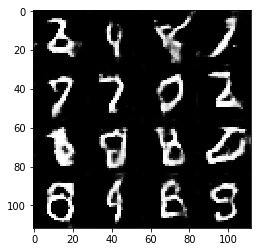

Timestamp 20170801-03-51-46.904 -  Epoch 1/2 -  Step 710 -  D Loss: 0.9735 - G Loss: 1.0465
Timestamp 20170801-03-51-59.397 -  Epoch 1/2 -  Step 720 -  D Loss: 1.2749 - G Loss: 0.7301
Timestamp 20170801-03-52-11.975 -  Epoch 1/2 -  Step 730 -  D Loss: 1.3829 - G Loss: 2.9682
Timestamp 20170801-03-52-24.569 -  Epoch 1/2 -  Step 740 -  D Loss: 1.1647 - G Loss: 0.7654
Timestamp 20170801-03-52-37.167 -  Epoch 1/2 -  Step 750 -  D Loss: 1.1382 - G Loss: 0.9722
Timestamp 20170801-03-52-49.804 -  Epoch 1/2 -  Step 760 -  D Loss: 1.0258 - G Loss: 1.0979
Timestamp 20170801-03-53-02.451 -  Epoch 1/2 -  Step 770 -  D Loss: 0.9500 - G Loss: 1.3305
Timestamp 20170801-03-53-14.655 -  Epoch 1/2 -  Step 780 -  D Loss: 1.0523 - G Loss: 0.9304
Timestamp 20170801-03-53-26.813 -  Epoch 1/2 -  Step 790 -  D Loss: 1.9368 - G Loss: 0.4221
Timestamp 20170801-03-53-38.917 -  Epoch 1/2 -  Step 800 -  D Loss: 1.1937 - G Loss: 0.8628


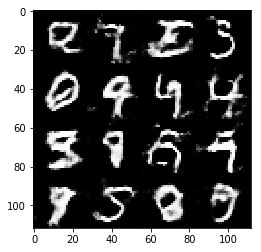

Timestamp 20170801-03-53-51.560 -  Epoch 1/2 -  Step 810 -  D Loss: 0.9492 - G Loss: 1.5614
Timestamp 20170801-03-54-03.658 -  Epoch 1/2 -  Step 820 -  D Loss: 0.9563 - G Loss: 1.1762
Timestamp 20170801-03-54-15.788 -  Epoch 1/2 -  Step 830 -  D Loss: 1.0332 - G Loss: 1.0670
Timestamp 20170801-03-54-27.905 -  Epoch 1/2 -  Step 840 -  D Loss: 0.9422 - G Loss: 2.2652
Timestamp 20170801-03-54-40.019 -  Epoch 1/2 -  Step 850 -  D Loss: 0.7579 - G Loss: 1.5087
Timestamp 20170801-03-54-52.183 -  Epoch 1/2 -  Step 860 -  D Loss: 1.4528 - G Loss: 0.6970
Timestamp 20170801-03-55-04.326 -  Epoch 1/2 -  Step 870 -  D Loss: 1.1792 - G Loss: 0.8191
Timestamp 20170801-03-55-16.423 -  Epoch 1/2 -  Step 880 -  D Loss: 0.9057 - G Loss: 1.1959
Timestamp 20170801-03-55-28.566 -  Epoch 1/2 -  Step 890 -  D Loss: 0.9872 - G Loss: 1.0737
Timestamp 20170801-03-55-40.689 -  Epoch 1/2 -  Step 900 -  D Loss: 1.1110 - G Loss: 1.0036


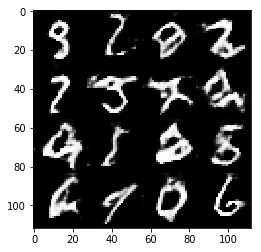

Timestamp 20170801-03-55-53.218 -  Epoch 1/2 -  Step 910 -  D Loss: 0.8653 - G Loss: 1.5353
Timestamp 20170801-03-56-05.302 -  Epoch 1/2 -  Step 920 -  D Loss: 0.9407 - G Loss: 1.1920
Timestamp 20170801-03-56-17.437 -  Epoch 1/2 -  Step 930 -  D Loss: 1.1128 - G Loss: 0.8857
Timestamp 20170801-03-56-26.024 -  Epoch 1/2 -  Step 937 -  D Loss: 0.9316 - G Loss: 1.2852


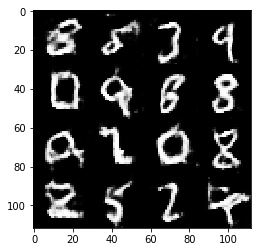

Timestamp 20170801-03-56-30.354 -  Epoch 2/2 -  Step 940 -  D Loss: 1.5748 - G Loss: 0.5818
Timestamp 20170801-03-56-42.476 -  Epoch 2/2 -  Step 950 -  D Loss: 0.8852 - G Loss: 1.3047
Timestamp 20170801-03-56-54.594 -  Epoch 2/2 -  Step 960 -  D Loss: 1.5085 - G Loss: 0.6058
Timestamp 20170801-03-57-06.685 -  Epoch 2/2 -  Step 970 -  D Loss: 1.0052 - G Loss: 1.2476
Timestamp 20170801-03-57-18.795 -  Epoch 2/2 -  Step 980 -  D Loss: 1.0883 - G Loss: 1.4190
Timestamp 20170801-03-57-30.937 -  Epoch 2/2 -  Step 990 -  D Loss: 1.2066 - G Loss: 0.8158
Timestamp 20170801-03-57-43.093 -  Epoch 2/2 -  Step 1000 -  D Loss: 1.1832 - G Loss: 1.1354


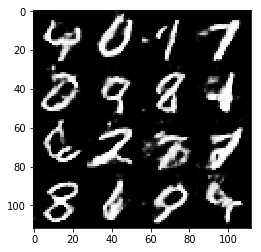

Timestamp 20170801-03-57-55.676 -  Epoch 2/2 -  Step 1010 -  D Loss: 1.0073 - G Loss: 1.0272
Timestamp 20170801-03-58-07.783 -  Epoch 2/2 -  Step 1020 -  D Loss: 0.9264 - G Loss: 1.2401
Timestamp 20170801-03-58-19.910 -  Epoch 2/2 -  Step 1030 -  D Loss: 0.8878 - G Loss: 1.2739
Timestamp 20170801-03-58-32.026 -  Epoch 2/2 -  Step 1040 -  D Loss: 1.2333 - G Loss: 0.8034
Timestamp 20170801-03-58-44.113 -  Epoch 2/2 -  Step 1050 -  D Loss: 0.9622 - G Loss: 2.4771
Timestamp 20170801-03-58-56.213 -  Epoch 2/2 -  Step 1060 -  D Loss: 1.0271 - G Loss: 1.6630
Timestamp 20170801-03-59-08.361 -  Epoch 2/2 -  Step 1070 -  D Loss: 1.0780 - G Loss: 1.0648
Timestamp 20170801-03-59-20.501 -  Epoch 2/2 -  Step 1080 -  D Loss: 1.1446 - G Loss: 0.8879
Timestamp 20170801-03-59-32.589 -  Epoch 2/2 -  Step 1090 -  D Loss: 1.0314 - G Loss: 0.9928
Timestamp 20170801-03-59-44.693 -  Epoch 2/2 -  Step 1100 -  D Loss: 1.0214 - G Loss: 1.3161


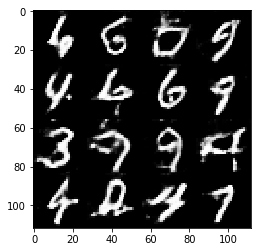

Timestamp 20170801-03-59-57.209 -  Epoch 2/2 -  Step 1110 -  D Loss: 1.1376 - G Loss: 0.8260
Timestamp 20170801-04-00-09.310 -  Epoch 2/2 -  Step 1120 -  D Loss: 1.0881 - G Loss: 2.5723
Timestamp 20170801-04-00-21.380 -  Epoch 2/2 -  Step 1130 -  D Loss: 1.3628 - G Loss: 0.7256
Timestamp 20170801-04-00-33.490 -  Epoch 2/2 -  Step 1140 -  D Loss: 1.2549 - G Loss: 0.8645
Timestamp 20170801-04-00-45.579 -  Epoch 2/2 -  Step 1150 -  D Loss: 1.4929 - G Loss: 0.4905
Timestamp 20170801-04-00-57.705 -  Epoch 2/2 -  Step 1160 -  D Loss: 1.0337 - G Loss: 1.3364
Timestamp 20170801-04-01-09.805 -  Epoch 2/2 -  Step 1170 -  D Loss: 1.1102 - G Loss: 0.9332
Timestamp 20170801-04-01-21.895 -  Epoch 2/2 -  Step 1180 -  D Loss: 1.1033 - G Loss: 0.9598
Timestamp 20170801-04-01-33.974 -  Epoch 2/2 -  Step 1190 -  D Loss: 1.0100 - G Loss: 1.1009
Timestamp 20170801-04-01-46.127 -  Epoch 2/2 -  Step 1200 -  D Loss: 1.6724 - G Loss: 0.4603


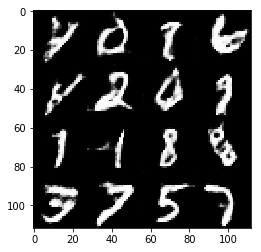

Timestamp 20170801-04-01-58.679 -  Epoch 2/2 -  Step 1210 -  D Loss: 1.0156 - G Loss: 0.9766
Timestamp 20170801-04-02-10.776 -  Epoch 2/2 -  Step 1220 -  D Loss: 0.9963 - G Loss: 1.5303
Timestamp 20170801-04-02-22.851 -  Epoch 2/2 -  Step 1230 -  D Loss: 0.9653 - G Loss: 1.2738
Timestamp 20170801-04-02-34.946 -  Epoch 2/2 -  Step 1240 -  D Loss: 1.0787 - G Loss: 0.9574
Timestamp 20170801-04-02-47.029 -  Epoch 2/2 -  Step 1250 -  D Loss: 1.4851 - G Loss: 0.5351
Timestamp 20170801-04-02-59.136 -  Epoch 2/2 -  Step 1260 -  D Loss: 1.0805 - G Loss: 0.8937
Timestamp 20170801-04-03-11.243 -  Epoch 2/2 -  Step 1270 -  D Loss: 1.9939 - G Loss: 0.3104
Timestamp 20170801-04-03-23.369 -  Epoch 2/2 -  Step 1280 -  D Loss: 1.0727 - G Loss: 0.9989
Timestamp 20170801-04-03-35.470 -  Epoch 2/2 -  Step 1290 -  D Loss: 1.2506 - G Loss: 0.7085
Timestamp 20170801-04-03-47.551 -  Epoch 2/2 -  Step 1300 -  D Loss: 0.8886 - G Loss: 2.5712


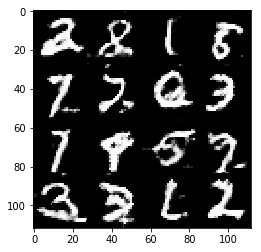

Timestamp 20170801-04-04-00.130 -  Epoch 2/2 -  Step 1310 -  D Loss: 0.9562 - G Loss: 1.1328
Timestamp 20170801-04-04-12.198 -  Epoch 2/2 -  Step 1320 -  D Loss: 1.2079 - G Loss: 1.2680
Timestamp 20170801-04-04-24.297 -  Epoch 2/2 -  Step 1330 -  D Loss: 1.0570 - G Loss: 1.0917
Timestamp 20170801-04-04-36.369 -  Epoch 2/2 -  Step 1340 -  D Loss: 0.9017 - G Loss: 1.3967
Timestamp 20170801-04-04-48.461 -  Epoch 2/2 -  Step 1350 -  D Loss: 2.2995 - G Loss: 0.2607
Timestamp 20170801-04-05-00.602 -  Epoch 2/2 -  Step 1360 -  D Loss: 1.3230 - G Loss: 0.7689
Timestamp 20170801-04-05-12.717 -  Epoch 2/2 -  Step 1370 -  D Loss: 1.0672 - G Loss: 1.0581
Timestamp 20170801-04-05-24.824 -  Epoch 2/2 -  Step 1380 -  D Loss: 1.0762 - G Loss: 1.0105
Timestamp 20170801-04-05-36.928 -  Epoch 2/2 -  Step 1390 -  D Loss: 0.9936 - G Loss: 1.2297
Timestamp 20170801-04-05-49.030 -  Epoch 2/2 -  Step 1400 -  D Loss: 1.1385 - G Loss: 1.1062


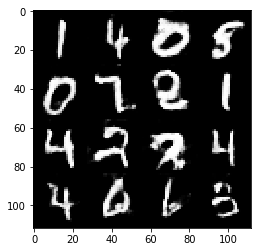

Timestamp 20170801-04-06-01.594 -  Epoch 2/2 -  Step 1410 -  D Loss: 1.1585 - G Loss: 0.8405
Timestamp 20170801-04-06-13.721 -  Epoch 2/2 -  Step 1420 -  D Loss: 1.1860 - G Loss: 0.8665
Timestamp 20170801-04-06-25.859 -  Epoch 2/2 -  Step 1430 -  D Loss: 1.2314 - G Loss: 0.7828
Timestamp 20170801-04-06-37.951 -  Epoch 2/2 -  Step 1440 -  D Loss: 1.0546 - G Loss: 0.9719
Timestamp 20170801-04-06-50.193 -  Epoch 2/2 -  Step 1450 -  D Loss: 1.3214 - G Loss: 0.6439
Timestamp 20170801-04-07-02.728 -  Epoch 2/2 -  Step 1460 -  D Loss: 1.2276 - G Loss: 0.7281
Timestamp 20170801-04-07-15.310 -  Epoch 2/2 -  Step 1470 -  D Loss: 1.1641 - G Loss: 0.8896
Timestamp 20170801-04-07-27.507 -  Epoch 2/2 -  Step 1480 -  D Loss: 1.0850 - G Loss: 1.5800
Timestamp 20170801-04-07-39.627 -  Epoch 2/2 -  Step 1490 -  D Loss: 1.1173 - G Loss: 0.9159
Timestamp 20170801-04-07-51.758 -  Epoch 2/2 -  Step 1500 -  D Loss: 1.0717 - G Loss: 1.0013


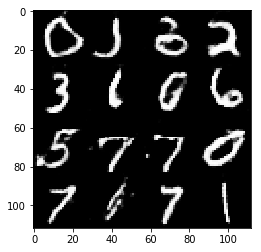

Timestamp 20170801-04-08-04.306 -  Epoch 2/2 -  Step 1510 -  D Loss: 1.0512 - G Loss: 0.9409
Timestamp 20170801-04-08-16.719 -  Epoch 2/2 -  Step 1520 -  D Loss: 1.2676 - G Loss: 0.6953
Timestamp 20170801-04-08-29.292 -  Epoch 2/2 -  Step 1530 -  D Loss: 1.2137 - G Loss: 2.4687
Timestamp 20170801-04-08-41.876 -  Epoch 2/2 -  Step 1540 -  D Loss: 0.9563 - G Loss: 1.0709
Timestamp 20170801-04-08-54.456 -  Epoch 2/2 -  Step 1550 -  D Loss: 0.9703 - G Loss: 1.3075
Timestamp 20170801-04-09-07.003 -  Epoch 2/2 -  Step 1560 -  D Loss: 1.2319 - G Loss: 2.0993
Timestamp 20170801-04-09-19.599 -  Epoch 2/2 -  Step 1570 -  D Loss: 1.0886 - G Loss: 0.9710
Timestamp 20170801-04-09-32.193 -  Epoch 2/2 -  Step 1580 -  D Loss: 1.4634 - G Loss: 0.5710
Timestamp 20170801-04-09-44.821 -  Epoch 2/2 -  Step 1590 -  D Loss: 1.3805 - G Loss: 2.1656
Timestamp 20170801-04-09-57.375 -  Epoch 2/2 -  Step 1600 -  D Loss: 1.2713 - G Loss: 1.0836


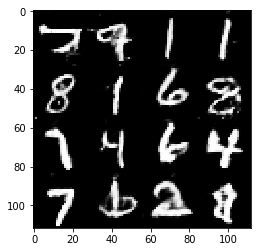

Timestamp 20170801-04-10-10.152 -  Epoch 2/2 -  Step 1610 -  D Loss: 1.6988 - G Loss: 0.3960
Timestamp 20170801-04-10-22.568 -  Epoch 2/2 -  Step 1620 -  D Loss: 1.0584 - G Loss: 0.9927
Timestamp 20170801-04-10-35.152 -  Epoch 2/2 -  Step 1630 -  D Loss: 1.1674 - G Loss: 0.8024
Timestamp 20170801-04-10-47.687 -  Epoch 2/2 -  Step 1640 -  D Loss: 1.3302 - G Loss: 0.6176
Timestamp 20170801-04-11-00.282 -  Epoch 2/2 -  Step 1650 -  D Loss: 0.9386 - G Loss: 1.2549
Timestamp 20170801-04-11-12.871 -  Epoch 2/2 -  Step 1660 -  D Loss: 1.1650 - G Loss: 0.7666
Timestamp 20170801-04-11-25.449 -  Epoch 2/2 -  Step 1670 -  D Loss: 0.9648 - G Loss: 1.2263
Timestamp 20170801-04-11-37.665 -  Epoch 2/2 -  Step 1680 -  D Loss: 0.9700 - G Loss: 1.0712
Timestamp 20170801-04-11-49.773 -  Epoch 2/2 -  Step 1690 -  D Loss: 1.3939 - G Loss: 0.5066
Timestamp 20170801-04-12-01.918 -  Epoch 2/2 -  Step 1700 -  D Loss: 1.4830 - G Loss: 0.4663


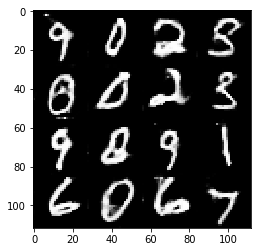

Timestamp 20170801-04-12-14.892 -  Epoch 2/2 -  Step 1710 -  D Loss: 0.9460 - G Loss: 1.3717
Timestamp 20170801-04-12-27.132 -  Epoch 2/2 -  Step 1720 -  D Loss: 1.4460 - G Loss: 0.5508
Timestamp 20170801-04-12-39.644 -  Epoch 2/2 -  Step 1730 -  D Loss: 1.9720 - G Loss: 0.3004
Timestamp 20170801-04-12-52.214 -  Epoch 2/2 -  Step 1740 -  D Loss: 1.1000 - G Loss: 0.8369
Timestamp 20170801-04-13-04.828 -  Epoch 2/2 -  Step 1750 -  D Loss: 0.9476 - G Loss: 1.8514
Timestamp 20170801-04-13-17.420 -  Epoch 2/2 -  Step 1760 -  D Loss: 0.8960 - G Loss: 2.0445
Timestamp 20170801-04-13-30.014 -  Epoch 2/2 -  Step 1770 -  D Loss: 1.1298 - G Loss: 0.8335
Timestamp 20170801-04-13-42.587 -  Epoch 2/2 -  Step 1780 -  D Loss: 1.0780 - G Loss: 0.8229
Timestamp 20170801-04-13-55.238 -  Epoch 2/2 -  Step 1790 -  D Loss: 0.9343 - G Loss: 1.0915
Timestamp 20170801-04-14-07.739 -  Epoch 2/2 -  Step 1800 -  D Loss: 1.5068 - G Loss: 0.6710


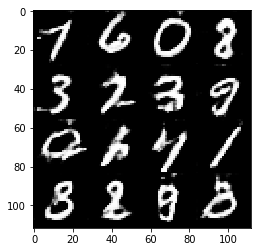

Timestamp 20170801-04-14-20.971 -  Epoch 2/2 -  Step 1810 -  D Loss: 1.5465 - G Loss: 0.5415
Timestamp 20170801-04-14-33.061 -  Epoch 2/2 -  Step 1820 -  D Loss: 1.5677 - G Loss: 0.5308
Timestamp 20170801-04-14-45.163 -  Epoch 2/2 -  Step 1830 -  D Loss: 1.0817 - G Loss: 0.8884
Timestamp 20170801-04-14-57.338 -  Epoch 2/2 -  Step 1840 -  D Loss: 1.2916 - G Loss: 0.7780
Timestamp 20170801-04-15-09.504 -  Epoch 2/2 -  Step 1850 -  D Loss: 1.3876 - G Loss: 0.6875
Timestamp 20170801-04-15-21.879 -  Epoch 2/2 -  Step 1860 -  D Loss: 1.2223 - G Loss: 0.7356
Timestamp 20170801-04-15-34.508 -  Epoch 2/2 -  Step 1870 -  D Loss: 1.7280 - G Loss: 0.3523
Timestamp 20170801-04-15-39.674 -  Epoch 2/2 -  Step 1874 -  D Loss: 0.9603 - G Loss: 1.2361


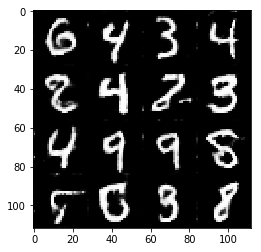

In [18]:
batch_size = 64
z_dim = 100
learning_rate = 0.005
beta1 = 0.5

tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Timestamp 20170801-08-43-15.281 -  Epoch 1/1 -  Step 10 -  D Loss: 0.8122 - G Loss: 11.6654
Timestamp 20170801-08-43-44.338 -  Epoch 1/1 -  Step 20 -  D Loss: 1.0353 - G Loss: 3.0335
Timestamp 20170801-08-44-15.510 -  Epoch 1/1 -  Step 30 -  D Loss: 1.3492 - G Loss: 0.9074
Timestamp 20170801-08-44-45.478 -  Epoch 1/1 -  Step 40 -  D Loss: 3.1327 - G Loss: 16.3828
Timestamp 20170801-08-45-13.407 -  Epoch 1/1 -  Step 50 -  D Loss: 0.9063 - G Loss: 1.9022
Timestamp 20170801-08-45-41.545 -  Epoch 1/1 -  Step 60 -  D Loss: 0.9475 - G Loss: 2.6787
Timestamp 20170801-08-46-08.144 -  Epoch 1/1 -  Step 70 -  D Loss: 0.9429 - G Loss: 1.3254
Timestamp 20170801-08-46-35.475 -  Epoch 1/1 -  Step 80 -  D Loss: 1.2614 - G Loss: 5.4709
Timestamp 20170801-08-47-01.991 -  Epoch 1/1 -  Step 90 -  D Loss: 1.3510 - G Loss: 0.6535
Timestamp 20170801-08-47-27.486 -  Epoch 1/1 -  Step 100 -  D Loss: 0.8088 - G Loss: 1.7529


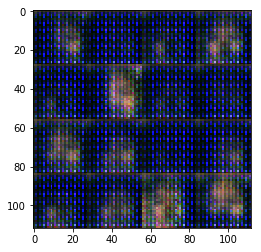

Timestamp 20170801-08-47-53.646 -  Epoch 1/1 -  Step 110 -  D Loss: 1.8463 - G Loss: 6.6379
Timestamp 20170801-08-48-19.635 -  Epoch 1/1 -  Step 120 -  D Loss: 0.8128 - G Loss: 4.1971
Timestamp 20170801-08-48-45.760 -  Epoch 1/1 -  Step 130 -  D Loss: 1.5567 - G Loss: 0.6348
Timestamp 20170801-08-49-10.613 -  Epoch 1/1 -  Step 140 -  D Loss: 0.8122 - G Loss: 1.9900
Timestamp 20170801-08-49-35.491 -  Epoch 1/1 -  Step 150 -  D Loss: 0.8041 - G Loss: 2.9489
Timestamp 20170801-08-50-00.617 -  Epoch 1/1 -  Step 160 -  D Loss: 1.1095 - G Loss: 1.5553
Timestamp 20170801-08-50-26.379 -  Epoch 1/1 -  Step 170 -  D Loss: 0.8066 - G Loss: 1.7956
Timestamp 20170801-08-50-51.779 -  Epoch 1/1 -  Step 180 -  D Loss: 2.0328 - G Loss: 0.3242
Timestamp 20170801-08-51-16.869 -  Epoch 1/1 -  Step 190 -  D Loss: 1.6010 - G Loss: 0.5381
Timestamp 20170801-08-51-43.136 -  Epoch 1/1 -  Step 200 -  D Loss: 1.0019 - G Loss: 1.9740


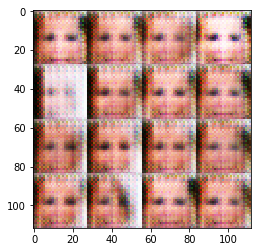

Timestamp 20170801-08-52-09.692 -  Epoch 1/1 -  Step 210 -  D Loss: 1.3835 - G Loss: 0.7489
Timestamp 20170801-08-52-35.098 -  Epoch 1/1 -  Step 220 -  D Loss: 0.6024 - G Loss: 2.7253
Timestamp 20170801-08-53-01.000 -  Epoch 1/1 -  Step 230 -  D Loss: 0.8515 - G Loss: 1.2528
Timestamp 20170801-08-53-26.174 -  Epoch 1/1 -  Step 240 -  D Loss: 0.7728 - G Loss: 1.9234
Timestamp 20170801-08-53-51.771 -  Epoch 1/1 -  Step 250 -  D Loss: 1.2332 - G Loss: 0.8623
Timestamp 20170801-08-54-17.364 -  Epoch 1/1 -  Step 260 -  D Loss: 1.1622 - G Loss: 2.2644
Timestamp 20170801-08-54-46.241 -  Epoch 1/1 -  Step 270 -  D Loss: 0.5619 - G Loss: 4.3454
Timestamp 20170801-08-55-12.061 -  Epoch 1/1 -  Step 280 -  D Loss: 1.5645 - G Loss: 2.9869
Timestamp 20170801-08-55-37.143 -  Epoch 1/1 -  Step 290 -  D Loss: 1.0098 - G Loss: 0.8537
Timestamp 20170801-08-56-02.410 -  Epoch 1/1 -  Step 300 -  D Loss: 0.5841 - G Loss: 2.9913


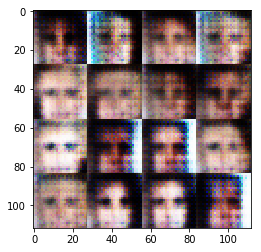

Timestamp 20170801-08-56-29.155 -  Epoch 1/1 -  Step 310 -  D Loss: 0.8832 - G Loss: 1.3002
Timestamp 20170801-08-56-54.903 -  Epoch 1/1 -  Step 320 -  D Loss: 0.4464 - G Loss: 3.3959
Timestamp 20170801-08-57-19.936 -  Epoch 1/1 -  Step 330 -  D Loss: 0.5738 - G Loss: 2.3058
Timestamp 20170801-08-57-45.785 -  Epoch 1/1 -  Step 340 -  D Loss: 1.1322 - G Loss: 0.7959
Timestamp 20170801-08-58-11.924 -  Epoch 1/1 -  Step 350 -  D Loss: 1.3633 - G Loss: 0.5742
Timestamp 20170801-08-58-36.960 -  Epoch 1/1 -  Step 360 -  D Loss: 0.7943 - G Loss: 1.2971
Timestamp 20170801-08-59-03.235 -  Epoch 1/1 -  Step 370 -  D Loss: 0.4768 - G Loss: 3.1491
Timestamp 20170801-08-59-28.801 -  Epoch 1/1 -  Step 380 -  D Loss: 1.0405 - G Loss: 0.9857
Timestamp 20170801-08-59-53.969 -  Epoch 1/1 -  Step 390 -  D Loss: 1.3999 - G Loss: 0.5764
Timestamp 20170801-09-00-19.411 -  Epoch 1/1 -  Step 400 -  D Loss: 1.1659 - G Loss: 0.8817


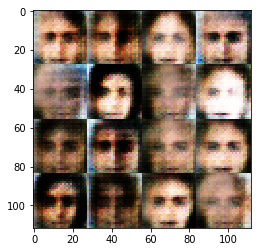

Timestamp 20170801-09-00-45.598 -  Epoch 1/1 -  Step 410 -  D Loss: 1.1603 - G Loss: 3.8416
Timestamp 20170801-09-01-10.497 -  Epoch 1/1 -  Step 420 -  D Loss: 1.1958 - G Loss: 0.9597
Timestamp 20170801-09-01-35.786 -  Epoch 1/1 -  Step 430 -  D Loss: 0.6921 - G Loss: 1.4065
Timestamp 20170801-09-02-01.496 -  Epoch 1/1 -  Step 440 -  D Loss: 0.7300 - G Loss: 2.5481
Timestamp 20170801-09-02-28.380 -  Epoch 1/1 -  Step 450 -  D Loss: 0.7357 - G Loss: 1.4554
Timestamp 20170801-09-02-53.965 -  Epoch 1/1 -  Step 460 -  D Loss: 0.4724 - G Loss: 3.5043
Timestamp 20170801-09-03-20.151 -  Epoch 1/1 -  Step 470 -  D Loss: 0.6659 - G Loss: 1.9083
Timestamp 20170801-09-03-48.410 -  Epoch 1/1 -  Step 480 -  D Loss: 0.5629 - G Loss: 3.2483
Timestamp 20170801-09-04-14.205 -  Epoch 1/1 -  Step 490 -  D Loss: 0.6870 - G Loss: 2.0295
Timestamp 20170801-09-04-42.214 -  Epoch 1/1 -  Step 500 -  D Loss: 0.8874 - G Loss: 1.0579


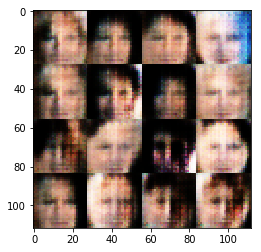

Timestamp 20170801-09-05-08.228 -  Epoch 1/1 -  Step 510 -  D Loss: 0.9026 - G Loss: 1.4887
Timestamp 20170801-09-05-32.720 -  Epoch 1/1 -  Step 520 -  D Loss: 0.8494 - G Loss: 5.0980
Timestamp 20170801-09-05-57.614 -  Epoch 1/1 -  Step 530 -  D Loss: 0.6649 - G Loss: 4.5125
Timestamp 20170801-09-06-22.941 -  Epoch 1/1 -  Step 540 -  D Loss: 0.3839 - G Loss: 5.0339
Timestamp 20170801-09-06-47.656 -  Epoch 1/1 -  Step 550 -  D Loss: 0.8660 - G Loss: 1.4130
Timestamp 20170801-09-07-13.664 -  Epoch 1/1 -  Step 560 -  D Loss: 1.4627 - G Loss: 0.7337
Timestamp 20170801-09-07-38.647 -  Epoch 1/1 -  Step 570 -  D Loss: 0.8141 - G Loss: 1.5281
Timestamp 20170801-09-08-03.867 -  Epoch 1/1 -  Step 580 -  D Loss: 0.9556 - G Loss: 1.3208
Timestamp 20170801-09-08-29.230 -  Epoch 1/1 -  Step 590 -  D Loss: 0.8338 - G Loss: 3.8210
Timestamp 20170801-09-08-55.088 -  Epoch 1/1 -  Step 600 -  D Loss: 0.8559 - G Loss: 1.6219


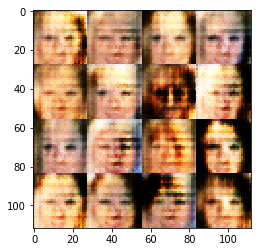

Timestamp 20170801-09-09-20.810 -  Epoch 1/1 -  Step 610 -  D Loss: 0.8503 - G Loss: 1.5055
Timestamp 20170801-09-09-45.922 -  Epoch 1/1 -  Step 620 -  D Loss: 0.5819 - G Loss: 2.1143
Timestamp 20170801-09-10-11.356 -  Epoch 1/1 -  Step 630 -  D Loss: 0.7921 - G Loss: 1.4004
Timestamp 20170801-09-10-35.771 -  Epoch 1/1 -  Step 640 -  D Loss: 1.0942 - G Loss: 3.7675
Timestamp 20170801-09-11-01.454 -  Epoch 1/1 -  Step 650 -  D Loss: 3.0043 - G Loss: 3.4349
Timestamp 20170801-09-11-26.139 -  Epoch 1/1 -  Step 660 -  D Loss: 1.0761 - G Loss: 1.1228
Timestamp 20170801-09-11-52.075 -  Epoch 1/1 -  Step 670 -  D Loss: 0.8876 - G Loss: 1.1584
Timestamp 20170801-09-12-18.257 -  Epoch 1/1 -  Step 680 -  D Loss: 0.8477 - G Loss: 2.7649
Timestamp 20170801-09-12-43.746 -  Epoch 1/1 -  Step 690 -  D Loss: 1.1715 - G Loss: 0.9391
Timestamp 20170801-09-13-09.494 -  Epoch 1/1 -  Step 700 -  D Loss: 1.0254 - G Loss: 0.9417


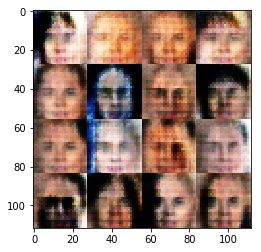

Timestamp 20170801-09-13-34.689 -  Epoch 1/1 -  Step 710 -  D Loss: 0.7766 - G Loss: 1.8520
Timestamp 20170801-09-13-59.667 -  Epoch 1/1 -  Step 720 -  D Loss: 1.0632 - G Loss: 1.8340
Timestamp 20170801-09-14-24.530 -  Epoch 1/1 -  Step 730 -  D Loss: 0.8062 - G Loss: 1.9831
Timestamp 20170801-09-14-50.005 -  Epoch 1/1 -  Step 740 -  D Loss: 0.8988 - G Loss: 1.3709
Timestamp 20170801-09-15-15.788 -  Epoch 1/1 -  Step 750 -  D Loss: 0.9360 - G Loss: 1.5180
Timestamp 20170801-09-15-41.067 -  Epoch 1/1 -  Step 760 -  D Loss: 1.2737 - G Loss: 3.0130
Timestamp 20170801-09-16-06.588 -  Epoch 1/1 -  Step 770 -  D Loss: 0.7909 - G Loss: 1.2392
Timestamp 20170801-09-16-31.630 -  Epoch 1/1 -  Step 780 -  D Loss: 0.8893 - G Loss: 1.8558
Timestamp 20170801-09-16-56.602 -  Epoch 1/1 -  Step 790 -  D Loss: 0.7348 - G Loss: 1.3993
Timestamp 20170801-09-17-22.252 -  Epoch 1/1 -  Step 800 -  D Loss: 1.5191 - G Loss: 0.4989


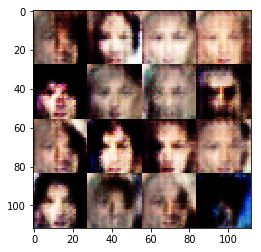

Timestamp 20170801-09-17-48.915 -  Epoch 1/1 -  Step 810 -  D Loss: 0.5239 - G Loss: 2.3996
Timestamp 20170801-09-18-13.876 -  Epoch 1/1 -  Step 820 -  D Loss: 0.5077 - G Loss: 3.1196
Timestamp 20170801-09-18-38.916 -  Epoch 1/1 -  Step 830 -  D Loss: 1.2867 - G Loss: 0.7715
Timestamp 20170801-09-19-05.030 -  Epoch 1/1 -  Step 840 -  D Loss: 0.5008 - G Loss: 2.2202
Timestamp 20170801-09-19-30.699 -  Epoch 1/1 -  Step 850 -  D Loss: 0.7514 - G Loss: 1.3646
Timestamp 20170801-09-19-56.416 -  Epoch 1/1 -  Step 860 -  D Loss: 0.8418 - G Loss: 1.1824
Timestamp 20170801-09-20-23.048 -  Epoch 1/1 -  Step 870 -  D Loss: 0.8771 - G Loss: 2.1547
Timestamp 20170801-09-20-48.101 -  Epoch 1/1 -  Step 880 -  D Loss: 1.0635 - G Loss: 0.9017
Timestamp 20170801-09-21-13.063 -  Epoch 1/1 -  Step 890 -  D Loss: 1.1930 - G Loss: 0.6803
Timestamp 20170801-09-21-38.273 -  Epoch 1/1 -  Step 900 -  D Loss: 1.3044 - G Loss: 3.4220


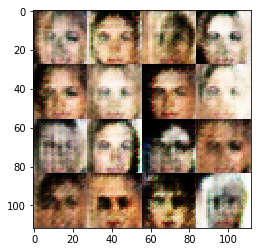

Timestamp 20170801-09-22-04.578 -  Epoch 1/1 -  Step 910 -  D Loss: 1.1644 - G Loss: 0.9651
Timestamp 20170801-09-22-29.271 -  Epoch 1/1 -  Step 920 -  D Loss: 0.8534 - G Loss: 2.4908
Timestamp 20170801-09-22-53.970 -  Epoch 1/1 -  Step 930 -  D Loss: 0.9039 - G Loss: 1.7782
Timestamp 20170801-09-23-19.203 -  Epoch 1/1 -  Step 940 -  D Loss: 0.7873 - G Loss: 1.4066
Timestamp 20170801-09-23-43.888 -  Epoch 1/1 -  Step 950 -  D Loss: 0.5490 - G Loss: 2.0490
Timestamp 20170801-09-24-09.200 -  Epoch 1/1 -  Step 960 -  D Loss: 0.7212 - G Loss: 2.2441
Timestamp 20170801-09-24-34.077 -  Epoch 1/1 -  Step 970 -  D Loss: 0.7849 - G Loss: 2.4196
Timestamp 20170801-09-24-58.917 -  Epoch 1/1 -  Step 980 -  D Loss: 0.6055 - G Loss: 1.7316
Timestamp 20170801-09-25-24.354 -  Epoch 1/1 -  Step 990 -  D Loss: 1.1537 - G Loss: 1.2175
Timestamp 20170801-09-25-51.521 -  Epoch 1/1 -  Step 1000 -  D Loss: 1.1812 - G Loss: 0.8828


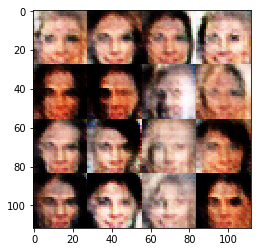

Timestamp 20170801-09-26-16.530 -  Epoch 1/1 -  Step 1010 -  D Loss: 0.6639 - G Loss: 6.2798
Timestamp 20170801-09-26-43.130 -  Epoch 1/1 -  Step 1020 -  D Loss: 2.1137 - G Loss: 0.4023
Timestamp 20170801-09-27-09.774 -  Epoch 1/1 -  Step 1030 -  D Loss: 0.7296 - G Loss: 1.3357
Timestamp 20170801-09-27-34.974 -  Epoch 1/1 -  Step 1040 -  D Loss: 0.6715 - G Loss: 1.9147
Timestamp 20170801-09-27-59.522 -  Epoch 1/1 -  Step 1050 -  D Loss: 0.9467 - G Loss: 1.4143
Timestamp 20170801-09-28-25.943 -  Epoch 1/1 -  Step 1060 -  D Loss: 0.6433 - G Loss: 1.7627
Timestamp 20170801-09-28-51.662 -  Epoch 1/1 -  Step 1070 -  D Loss: 1.0565 - G Loss: 1.0557
Timestamp 20170801-09-29-17.402 -  Epoch 1/1 -  Step 1080 -  D Loss: 0.9316 - G Loss: 1.0202
Timestamp 20170801-09-29-43.723 -  Epoch 1/1 -  Step 1090 -  D Loss: 0.9688 - G Loss: 1.2916
Timestamp 20170801-09-30-14.122 -  Epoch 1/1 -  Step 1100 -  D Loss: 1.1889 - G Loss: 0.8744


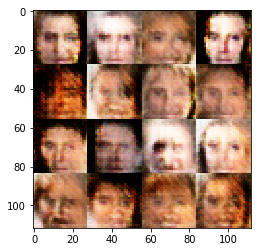

Timestamp 20170801-09-30-44.774 -  Epoch 1/1 -  Step 1110 -  D Loss: 0.4532 - G Loss: 3.1421
Timestamp 20170801-09-31-12.772 -  Epoch 1/1 -  Step 1120 -  D Loss: 0.8405 - G Loss: 1.7151
Timestamp 20170801-09-31-39.052 -  Epoch 1/1 -  Step 1130 -  D Loss: 0.7038 - G Loss: 1.7917
Timestamp 20170801-09-32-02.821 -  Epoch 1/1 -  Step 1140 -  D Loss: 1.0561 - G Loss: 0.8743
Timestamp 20170801-09-32-28.493 -  Epoch 1/1 -  Step 1150 -  D Loss: 0.5439 - G Loss: 2.4562
Timestamp 20170801-09-32-53.651 -  Epoch 1/1 -  Step 1160 -  D Loss: 1.0216 - G Loss: 2.4139
Timestamp 20170801-09-33-20.745 -  Epoch 1/1 -  Step 1170 -  D Loss: 0.9405 - G Loss: 1.2543
Timestamp 20170801-09-33-45.004 -  Epoch 1/1 -  Step 1180 -  D Loss: 1.2070 - G Loss: 0.7920
Timestamp 20170801-09-34-10.046 -  Epoch 1/1 -  Step 1190 -  D Loss: 0.7898 - G Loss: 1.3027
Timestamp 20170801-09-34-35.563 -  Epoch 1/1 -  Step 1200 -  D Loss: 1.3480 - G Loss: 0.7637


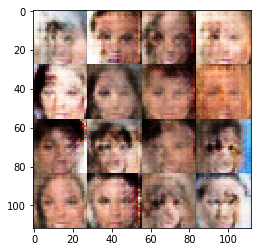

Timestamp 20170801-09-35-01.603 -  Epoch 1/1 -  Step 1210 -  D Loss: 0.9147 - G Loss: 2.8827
Timestamp 20170801-09-35-27.976 -  Epoch 1/1 -  Step 1220 -  D Loss: 1.1340 - G Loss: 0.8724
Timestamp 20170801-09-35-53.971 -  Epoch 1/1 -  Step 1230 -  D Loss: 0.8385 - G Loss: 1.3998
Timestamp 20170801-09-36-19.138 -  Epoch 1/1 -  Step 1240 -  D Loss: 0.6090 - G Loss: 1.7988
Timestamp 20170801-09-36-44.696 -  Epoch 1/1 -  Step 1250 -  D Loss: 1.0183 - G Loss: 0.9825
Timestamp 20170801-09-37-10.723 -  Epoch 1/1 -  Step 1260 -  D Loss: 1.0455 - G Loss: 2.8913
Timestamp 20170801-09-37-35.995 -  Epoch 1/1 -  Step 1270 -  D Loss: 0.9506 - G Loss: 2.3319
Timestamp 20170801-09-38-01.970 -  Epoch 1/1 -  Step 1280 -  D Loss: 0.7173 - G Loss: 1.6144
Timestamp 20170801-09-38-32.404 -  Epoch 1/1 -  Step 1290 -  D Loss: 0.9438 - G Loss: 2.3218
Timestamp 20170801-09-39-01.972 -  Epoch 1/1 -  Step 1300 -  D Loss: 1.0838 - G Loss: 4.1011


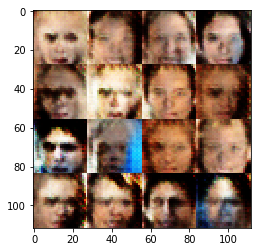

Timestamp 20170801-09-39-35.180 -  Epoch 1/1 -  Step 1310 -  D Loss: 0.6998 - G Loss: 1.4636
Timestamp 20170801-09-40-09.723 -  Epoch 1/1 -  Step 1320 -  D Loss: 1.0271 - G Loss: 0.9927
Timestamp 20170801-09-40-40.366 -  Epoch 1/1 -  Step 1330 -  D Loss: 1.3208 - G Loss: 3.0948
Timestamp 20170801-09-41-06.667 -  Epoch 1/1 -  Step 1340 -  D Loss: 0.5264 - G Loss: 2.1579
Timestamp 20170801-09-41-33.139 -  Epoch 1/1 -  Step 1350 -  D Loss: 0.6479 - G Loss: 1.8059
Timestamp 20170801-09-42-00.174 -  Epoch 1/1 -  Step 1360 -  D Loss: 0.8837 - G Loss: 1.0410
Timestamp 20170801-09-42-26.385 -  Epoch 1/1 -  Step 1370 -  D Loss: 0.6711 - G Loss: 1.7172
Timestamp 20170801-09-42-52.479 -  Epoch 1/1 -  Step 1380 -  D Loss: 0.9071 - G Loss: 1.0042
Timestamp 20170801-09-43-18.303 -  Epoch 1/1 -  Step 1390 -  D Loss: 0.7867 - G Loss: 1.2545
Timestamp 20170801-09-43-43.358 -  Epoch 1/1 -  Step 1400 -  D Loss: 1.0981 - G Loss: 2.2970


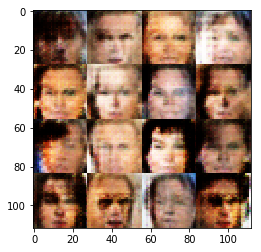

Timestamp 20170801-09-44-10.007 -  Epoch 1/1 -  Step 1410 -  D Loss: 1.8116 - G Loss: 0.5458
Timestamp 20170801-09-44-36.373 -  Epoch 1/1 -  Step 1420 -  D Loss: 0.7614 - G Loss: 1.5289
Timestamp 20170801-09-45-02.781 -  Epoch 1/1 -  Step 1430 -  D Loss: 0.9608 - G Loss: 1.1755
Timestamp 20170801-09-45-30.094 -  Epoch 1/1 -  Step 1440 -  D Loss: 0.7261 - G Loss: 1.6303
Timestamp 20170801-09-45-55.673 -  Epoch 1/1 -  Step 1450 -  D Loss: 0.8078 - G Loss: 1.6451
Timestamp 20170801-09-46-21.486 -  Epoch 1/1 -  Step 1460 -  D Loss: 0.8104 - G Loss: 1.3250
Timestamp 20170801-09-46-47.048 -  Epoch 1/1 -  Step 1470 -  D Loss: 0.6690 - G Loss: 2.0695
Timestamp 20170801-09-47-12.648 -  Epoch 1/1 -  Step 1480 -  D Loss: 1.2159 - G Loss: 2.5262
Timestamp 20170801-09-47-38.384 -  Epoch 1/1 -  Step 1490 -  D Loss: 0.9726 - G Loss: 1.0124
Timestamp 20170801-09-48-03.891 -  Epoch 1/1 -  Step 1500 -  D Loss: 0.8665 - G Loss: 1.2085


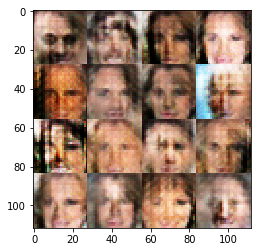

Timestamp 20170801-09-48-29.706 -  Epoch 1/1 -  Step 1510 -  D Loss: 0.9557 - G Loss: 0.9835
Timestamp 20170801-09-48-54.909 -  Epoch 1/1 -  Step 1520 -  D Loss: 0.8092 - G Loss: 1.1631
Timestamp 20170801-09-49-20.467 -  Epoch 1/1 -  Step 1530 -  D Loss: 0.9260 - G Loss: 1.4285
Timestamp 20170801-09-49-45.520 -  Epoch 1/1 -  Step 1540 -  D Loss: 0.9802 - G Loss: 1.1218
Timestamp 20170801-09-50-10.305 -  Epoch 1/1 -  Step 1550 -  D Loss: 0.7947 - G Loss: 1.3315
Timestamp 20170801-09-50-35.193 -  Epoch 1/1 -  Step 1560 -  D Loss: 1.1460 - G Loss: 1.6390
Timestamp 20170801-09-51-00.503 -  Epoch 1/1 -  Step 1570 -  D Loss: 0.7830 - G Loss: 1.9578
Timestamp 20170801-09-51-25.283 -  Epoch 1/1 -  Step 1580 -  D Loss: 1.1091 - G Loss: 1.7980
Timestamp 20170801-09-51-30.453 -  Epoch 1/1 -  Step 1582 -  D Loss: 1.0288 - G Loss: 2.4614


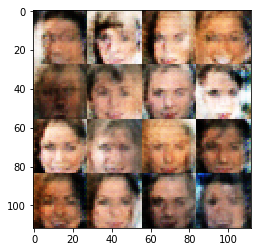

In [26]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5

tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.